In [11]:
import category_encoders as ce
from category_encoders import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [16]:
def wrangle(df):
  # feature creation
  df['blue_vision_score'] = df['blueWardsPlaced'] + df['redWardsDestroyed']
  df['red_vision_score'] = df['redWardsPlaced'] + df['blueWardsDestroyed']
  df['blue_npc_score'] = df['blueHeralds'] + df['blueDragons'] + df['blueTowersDestroyed']
  df['red_npc_score'] = df['redHeralds'] + df['redDragons'] + df['redTowersDestroyed']

  return df

In [17]:
df = pd.read_csv('data\high_diamond_ranked_10min.csv',
                 index_col='gameId')
wrangle(df)

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blue_vision_score,red_vision_score,blue_npc_score,red_npc_score
gameId,,,,,,,,,,,,,,,,,,,,,
4519157822,0,28,2,1,9,6,11,0,0,0,...,197,55,-643,8,19.7,1656.7,34,17,0,0
4523371949,0,12,1,0,5,5,5,0,0,0,...,240,52,2908,1173,24.0,1762.0,13,13,0,3
4521474530,0,15,0,0,7,11,4,1,1,0,...,203,28,1172,1033,20.3,1728.5,18,15,1,0
4524384067,0,43,1,0,4,5,5,1,0,1,...,235,47,1321,7,23.5,1647.8,45,16,1,0
4436033771,0,75,4,0,6,6,6,0,0,0,...,225,67,1004,-230,22.5,1740.4,77,21,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4527873286,1,17,2,1,7,4,5,1,1,0,...,229,34,-2519,-2469,22.9,1524.6,20,48,1,0
4527797466,1,54,0,0,6,4,8,1,1,0,...,206,56,-782,-888,20.6,1545.6,75,12,1,0
4527713716,0,23,1,0,6,7,5,0,0,0,...,261,60,2416,1877,26.1,1831.9,23,15,0,1


In [21]:
#Create feature/target martrix
target = 'blueWins'
y = df[target]
X = df.drop(columns=target)

In [24]:
# create training, validation, and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.15)

In [25]:
# establish baseline 
print('baseline accuracy:',y_train.value_counts(normalize=True).max())

baseline accuracy: 0.5008188179246688


In [26]:
# create a basic model and compare to baseline
rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier()
)
rf.fit(X_train, y_train)
print('training accuaracy score:', rf.score(X_train, y_train))
print('test accuaracy score:', rf.score(X_test, y_test))
# model performs better than baseline!

training accuaracy score: 1.0
test accuaracy score: 0.7090080971659919


In [27]:
#lets try hyperparameter tuning
params =  {'randomforestclassifier__n_estimators': np.arange(10,141,10),
          'randomforestclassifier__max_depth': np.arange(10,101,10),
          'randomforestclassifier__max_features': np.arange(5,41,5),
          'randomforestclassifier__max_samples': np.arange(0.2, 0.61, 0.1)}

rf_rs = RandomizedSearchCV(rf, params, cv=4, n_jobs=-1, verbose=1)
rf_rs.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=[],
                                                             mapping=[])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                                        'randomforestclassifier__max_features': array([ 5, 10, 15, 20, 25, 30, 35, 40]),
                                        'randomforestclassifier__max_samples': array([0.2, 0.3, 0.4, 0.5, 0.6]),
                                        'randomforestclassifier__n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140])},
                   verbose=1)

In [28]:
print('training accuaracy score:', rf_rs.score(X_train, y_train))
print('val accuaracy score:', rf_rs.score(X_val, y_val))

training accuaracy score: 0.9854101533422659
val accuaracy score: 0.7133220910623946


In [30]:
rf_gs = GridSearchCV(rf, params, cv=5, verbose=1, n_jobs=-1)
rf_gs.fit(X_train,y_train)

Fitting 5 folds for each of 5600 candidates, totalling 28000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=[], mapping=[])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                         'randomforestclassifier__max_features': array([ 5, 10, 15, 20, 25, 30, 35, 40]),
                         'randomforestclassifier__max_samples': array([0.2, 0.3, 0.4, 0.5, 0.6]),
                         'randomforestclassifier__n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140])},
             verbose=1)

In [33]:
best_params = rf_gs.best_params_
print(best_params)

{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 15, 'randomforestclassifier__max_samples': 0.6000000000000001, 'randomforestclassifier__n_estimators': 80}


In [34]:
# test tuned model
print('training accuaracy score:', rf_gs.score(X_train, y_train))
print('val accuaracy score:', rf_gs.score(X_val, y_val))

training accuaracy score: 0.8569301771624237
val accuaracy score: 0.7141652613827993


In [35]:
train_acc = []
val_acc = []
for depth in range(1, 30, 2):
  rf = make_pipeline(ce.OrdinalEncoder(),
                   SimpleImputer(),
                   RandomForestClassifier(max_depth=depth, random_state=42))
  rf.fit(X_train,y_train)
  train_acc.append(rf.score(X_train, y_train))
  val_acc.append(rf.score(X_val, y_val))

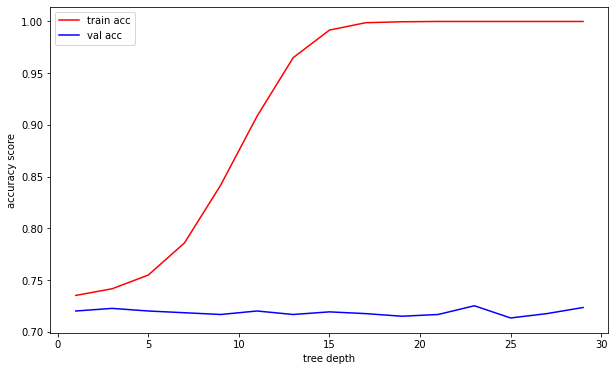

In [36]:
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(range(1, 30, 2), train_acc, color='red', label='train acc')
plt.plot(range(1, 30, 2), val_acc, color='blue', label='val acc')
plt.xlabel('tree depth')
plt.ylabel('accuracy score')
plt.legend()

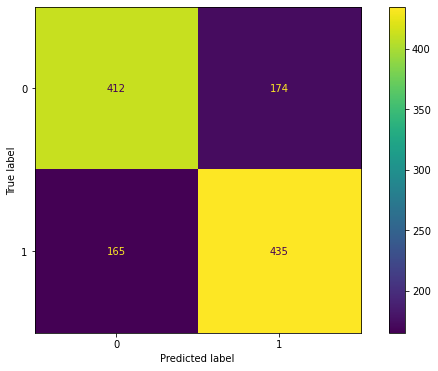

In [44]:
predy = rf_gs.predict(X_val)
plot_confusion_matrix(rf_gs, X_val,y_val)

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7140    0.7031    0.7085       586
           1     0.7143    0.7250    0.7196       600

    accuracy                         0.7142      1186
   macro avg     0.7142    0.7140    0.7141      1186
weighted avg     0.7142    0.7142    0.7141      1186



In [46]:
# create PR curve and PR Score
# predicted probabilities 
rf_gs.predict_proba(X_val)
# predicted probs for positive class
y_pred_prob = rf_gs.predict_proba(X_val)[:,1]

In [49]:
from ipywidgets import interact, fixed
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def my_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba > threshold
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    print(classification_report(y_true, y_pred))
    my_confusion_matrix(y_true, y_pred)

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_prob), 
         threshold=(0, 1, 0.02));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [59]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

ValueError: Found input variables with inconsistent numbers of samples: [1186, 1976]

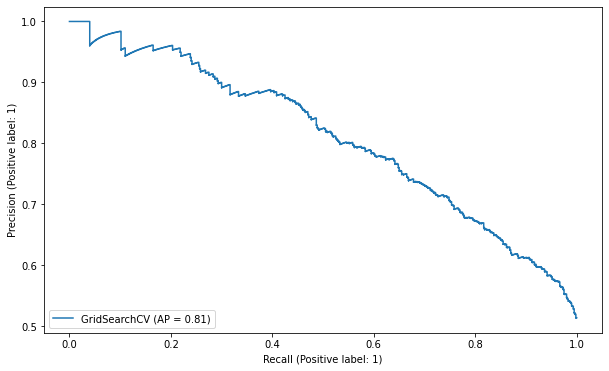

In [62]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(rf_gs, X_val, y_val)

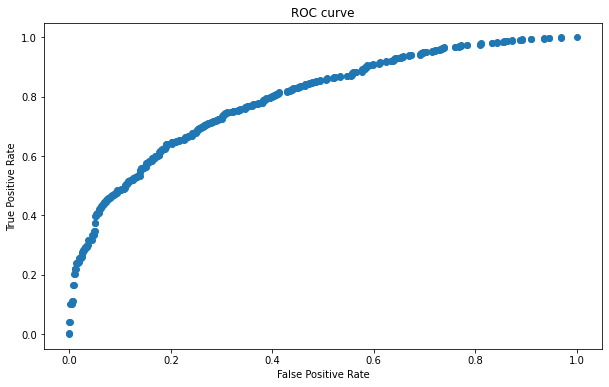

In [53]:
# See the results on a plot. 
# This is the "Receiver Operating Characteristic" curve
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [55]:
# Use scikit-learn to calculate the area under the curve.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_prob)

0.7952445961319681

In [57]:
from sklearn.metrics import roc_auc_score
y_pred_prob = rf_gs.predict_proba(X_test)[:, -1] # Probability for last class
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_prob))

Test ROC AUC: 0.7811952934423878
